In [89]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
from astropy.io import fits
import lightkurve as lk
import random

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

import scipy.interpolate as interp
import scipy

from PIL import Image
from PIL import ImageDraw
from PIL import ImageChops

%matplotlib inline

In [1365]:
mag_plot = {}
mag_plot['mag'] = []
mag_plot['observ'] = []

In [1366]:
circ_plot = {}
circ_plot['mag'] = []
circ_plot['circ'] = []
circ_plot['observ'] = []
circ_plot['label'] = []

In [1367]:
circ_plot['label'] = ["planet", "blocky planet", "blockier planet", "planet with large moon", "triangular shard", "pentagon", "triangle", "bars", "crescent moon", "square frame", "x", "two planets", "rodent spaceship", "elongated hexagon", "two rectangles", "prime number bars", "dust patches", "checkerboard frame", "semi-circles", "diamond"]
# planet, blocky planet, blockier planet, planet with large moon, triangular shard, pentagon, triangle, bars, crescent moon, square frame, x, two planets, rodent spaceship, elongated hexagon, two rectangles, prime number bars

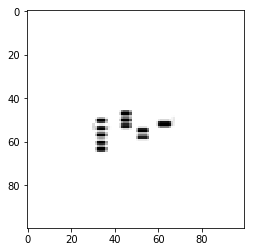

In [1760]:
# opening up the artificial image
name = "primeship"
first_im = Image.open("/Users/piperfrances/Downloads/primeship.png").convert('LA').convert('RGB')
plt.imshow(first_im)

Text(0.5,1,'Artificial Object')

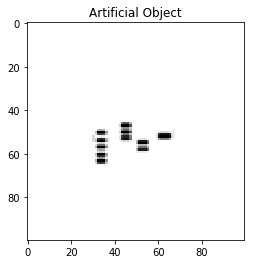

In [1761]:
label = "semi circles"
plt.imshow(first_im)
plt.title("Artificial Object")

In [1762]:
arr = np.array(Image.fromarray(np.asarray(first_im)).resize((100,100)))
img = Image.fromarray(arr)

In [1763]:
immat = img.load()
(X, Y) = img.size
m = np.zeros((X, Y))
area = 0

for x in range(X):
    for y in range(Y):
        m[x, y] = immat[(x, y)] != (255, 255, 255)
        if immat[(x, y)] == (0, 0, 0):
            #immat[(x, y)] = 0
            area = area + 1
m = m / np.sum(np.sum(m))

# marginal distributions
dx = np.sum(m, 1)
dy = np.sum(m, 0)

# expected values
cx = np.sum(dx * np.arange(X))
cy = np.sum(dy * np.arange(Y))

In [1764]:
area

25

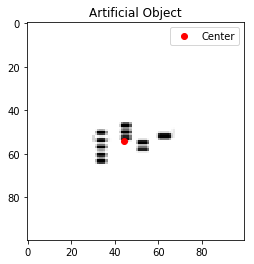

In [1765]:
plt.imshow(img)
plt.plot(cx, cy, 'o', color='red',label="Center")
plt.title("Artificial Object")
plt.legend()

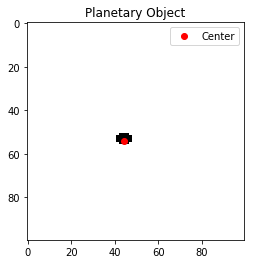

In [1766]:
# now we create a planetary object that's the same number of pixels
r = np.sqrt((area / np.pi))
size = (X, Y)
planimg = Image.new('L', size, color=10000000).convert('LA').convert('RGB')
draw = ImageDraw.Draw(planimg)

leftUpPoint = (cx-r, cy-r)
rightDownPoint = (cx+r, cy+r)
twoPointList = [leftUpPoint, rightDownPoint]
draw.ellipse(twoPointList, 0, 0,)

plt.plot(cx, cy, 'o', color = "red", label = "Center")
plt.legend()
plt.title("Planetary Object")
plt.imshow(planimg)

In [1767]:
planArr = np.array(Image.fromarray(np.asarray(planimg)))

sub_arr = np.subtract(planArr, arr)

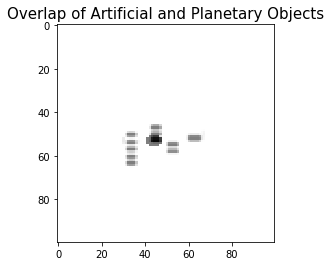

In [1768]:
sub_i = ImageChops.add(planimg, img, scale = 2.0, offset = 0)
plt.imshow(sub_i)
plt.title("Overlap of Artificial and Planetary Objects", fontsize=15)
plt.savefig("/Users/piperfrances/Downloads/overlap", fmt="png")

In [1769]:
(sx, sy, sz) = sub_arr.shape
(subX, subY) = sub_i.size

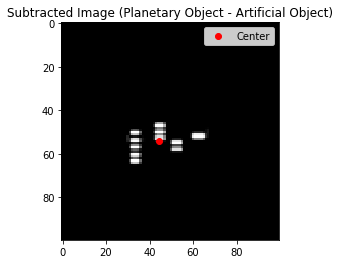

In [1770]:
sub_img = Image.fromarray(sub_arr)
plt.imshow(sub_img)
plt.title("Subtracted Image (Planetary Object - Artificial Object)")
plt.plot(cx, cy, 'o', color ="red", label="Center")
plt.legend()
plt.show()

In [1771]:
num_dif = 0
# for x in range(sx):
#     for y in range(sy):
#         for z in range(sz):
#             if arr[x][y][z] > 100:
#                 num_dif = num_dif + 1

black = 0
white = 0
gray = 0
other = 0
p_list = []
for pixel in sub_i.getdata():
    if pixel == (0, 0, 0): # if your image is RGB (if RGBA, (0, 0, 0, 255) or so
        black += 1
    if pixel == (127, 127, 127):
        gray += 1
    if pixel == (255, 255, 255): # if your image is RGB (if RGBA, (0, 0, 0, 255) or so
        white += 1
    else:
        other += 1
        p_list = np.append(p_list, pixel)


In [1772]:
percent_dif = (gray / area) * 100
percent_dif

136.0

In [1773]:
#percent_dif = (num_dif / area) * 100

In [1774]:
#percent_dif = 100.0

In [1775]:
# save it up!
img_file = "/Users/piperfrances/BSRC/code/circularity/artifact.png"
planet_file = "/Users/piperfrances/BSRC/code/circularity/planet.png"
sub_file = "/Users/piperfrances/BSRC/code/circularity/subtraction.png"
img.save(img_file,)
planimg.save(planet_file,)
sub_img.save(sub_file,)

/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()
/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


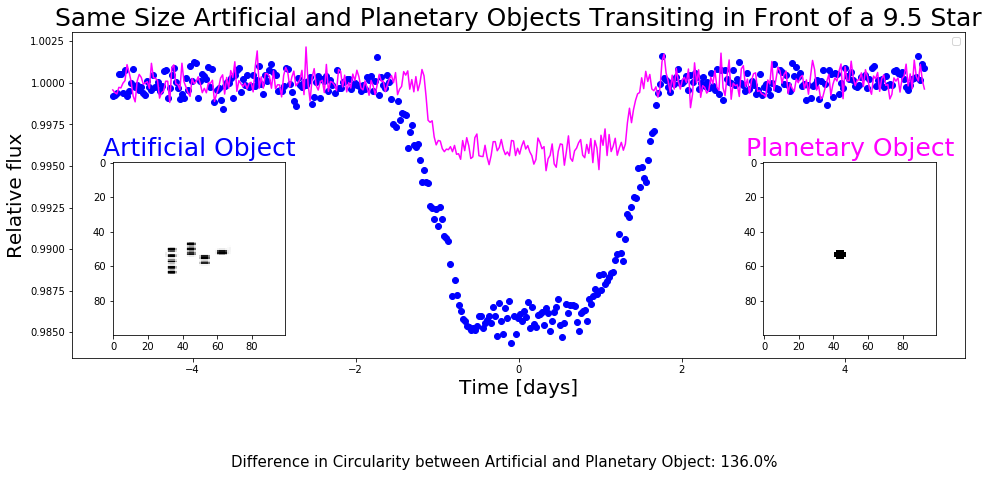

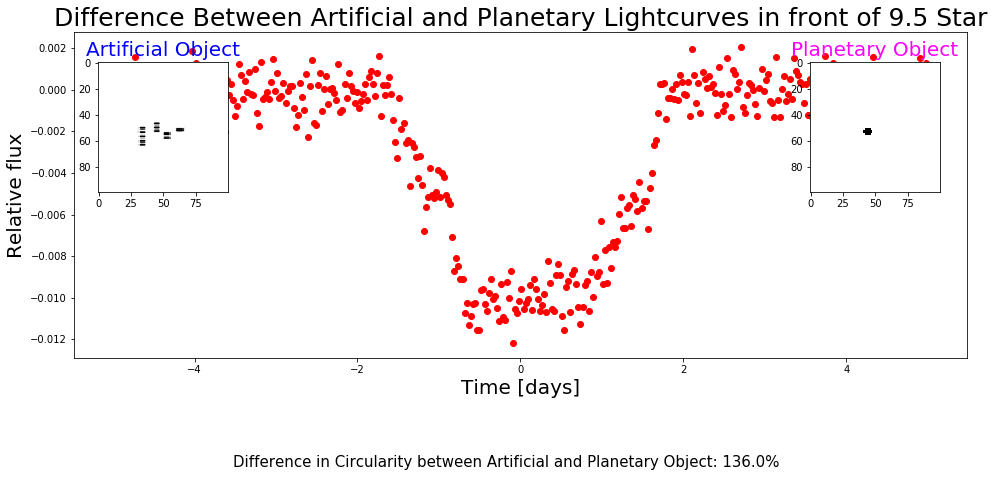

In [1776]:
times = np.linspace(-35.,35.,500)
artificial_lowres_SItitle = TransitingImage(imfile=img_file,
                                    lowres=100,
                                    lowrestype="mean", # Calculate the lower-resolution version of the image by averaging "neighborhoods" of pixels in the high-res image.
                                    lowresround=False, # Let the resulting low-res pixel values take on intermediate values between 0 and 1, i.e. don't round them to 0 or 1.
                                    v=0.4,
                                    t_ref=0.,
                                    t_arr=times)

planet_lowres_SItitle = TransitingImage(imfile=planet_file,
                                    lowres=100,
                                    lowrestype="mean", # Calculate the lower-resolution version of the image by averaging "neighborhoods" of pixels in the high-res image.
                                    lowresround=False, # Let the resulting low-res pixel values take on intermediate values between 0 and 1, i.e. don't round them to 0 or 1.
                                    v=0.4,
                                    t_ref=0.,
                                    t_arr=times)

m = 0.0006149042851666919 # as derived from TESS data
b = -0.005250374227956735
#mag_rand = random.uniform(8.5, 15.5)
mag_rand = 9.5
circ_plot['mag'] = mag_rand
stdev = ( mag_rand * m + b )
num_points = 200

mu, sigma = 1, stdev 
# creating a noise with the same dimension as the dataset (1,1) 
planet_noise = np.random.normal(mu, sigma, [int(num_points),]) 
artif_noise = np.random.normal(mu, sigma, [int(num_points),]) 

#lowres_SItitle.plot_grid()
#print np.shape(lowres_SItitle.opacitymat)
artificial_lowres_SItitle_LC, overlapTimes = artificial_lowres_SItitle.gen_LC(t_arr=times)  
planet_lowres_SItitle_LC, overlapTimes = planet_lowres_SItitle.gen_LC(t_arr=times) 

planet_intetp = interp.interp1d(np.arange(planet_lowres_SItitle_LC.size),planet_lowres_SItitle_LC)
planet_stretch = planet_intetp(np.linspace(0,planet_lowres_SItitle_LC.size-1,planet_noise.size))

artif_intetp = interp.interp1d(np.arange(artificial_lowres_SItitle_LC.size),artificial_lowres_SItitle_LC)
artif_stretch = artif_intetp(np.linspace(0,artificial_lowres_SItitle_LC.size-1,planet_noise.size))

non_transit = np.linspace(1.,1.,int(num_points/2))

non_t_noise_before_planet = np.random.normal(mu, sigma, [int(num_points/2),]) 
non_t_noise_after_planet = np.random.normal(mu, sigma, [int(num_points/2),])

non_t_noise_before_artif = np.random.normal(mu, sigma, [int(num_points/2),]) 
non_t_noise_after_artif = np.random.normal(mu, sigma, [int(num_points/2),])

before_p = non_t_noise_before_planet * non_transit
after_p = non_t_noise_after_planet * non_transit

before_a = non_t_noise_before_artif * non_transit
after_a = non_t_noise_after_artif * non_transit

planet_LC = []
planet_LC = np.append(planet_LC, before_p)
planet_LC = np.append(planet_LC, planet_stretch*planet_noise)
planet_LC = np.append(planet_LC, after_p)

artif_LC = []
artif_LC = np.append(artif_LC, before_a)
artif_LC = np.append(artif_LC, artif_stretch*artif_noise)
artif_LC = np.append(artif_LC, after_a)

# interpolating the smaller array

times_interp = interp.interp1d(np.arange(overlapTimes.size),overlapTimes)
times_stretch = times_interp(np.linspace(0,overlapTimes.size-1,planet_LC.size))

fig, ax = plt.subplots(1,1,figsize=(16,6))
ax = plt.axes()
ax.plot(times_stretch,artif_LC,'o',color="blue")
ax.plot(times_stretch,planet_LC,'-',color="magenta")
plt.xlabel("Time [days]",fontsize=20)
plt.ylabel("Relative flux",fontsize=20)
plt.title(r"Same Size Artificial and Planetary Objects Transiting in Front of a "+str(mag_rand)+" Star",fontsize=25)
ax1 = plt.axes([.035, .18, 0.4, 0.4])
ax1.imshow(artificial_lowres_SItitle.opacitymat,cmap="Greys",aspect="equal",origin="upper",interpolation='none',vmin=0.,vmax=1.)
#ax1.plot(cx,cy,'.',color ="red")
ax1.set_title("Artificial Object", color='blue',fontsize=25)
ax3 = plt.axes([.6, .18, 0.4, 0.4])
ax3.imshow(planet_lowres_SItitle.opacitymat,cmap="Greys",aspect="equal",origin="upper",interpolation='none',vmin=0.,vmax=1.)
#ax3.plot(cx,cy,'.',color ="red")
ax3.set_title("Planetary Object", color='magenta',fontsize=25)
ax.legend()

words_ax = plt.axes([.5, -.14, 0.0, 0.0])
words_ax.axis("off")
words_ax.set_title("Difference in Circularity between Artificial and Planetary Object: "+str(percent_dif)+"%",fontsize=15)

filename = "/Users/piperfrances/Downloads/piships" + name
plt.savefig(filename, fmt="png")

fig2, ax6 = plt.subplots(1,1,figsize=(16,6))
ax6 = plt.axes()
ax6.plot(times_stretch,(artif_LC - planet_LC),'o',color="red",label = "artificial transit - planetary transit")
plt.xlabel("Time [days]",fontsize=20)
plt.ylabel("Relative flux",fontsize=20)
plt.title(r"Difference Between Artificial and Planetary Lightcurves in front of "+str(mag_rand)+" Star",fontsize=25)
ax7 = plt.axes([.052, .51, 0.3, 0.3])
ax7.imshow(artificial_lowres_SItitle.opacitymat,cmap="Greys",aspect="equal",origin="upper",interpolation='none',vmin=0.,vmax=1.)
#ax1.plot(cx,cy,'.',color ="red")
ax7.set_title("Artificial Object", color='blue',fontsize=20)
ax8 = plt.axes([.67, .51, 0.3, 0.3])
ax8.imshow(planet_lowres_SItitle.opacitymat,cmap="Greys",aspect="equal",origin="upper",interpolation='none',vmin=0.,vmax=1.)
#ax3.plot(cx,cy,'.',color ="red")
ax8.set_title("Planetary Object", color='magenta',fontsize=20)
#ax6.legend()

words_ax1 = plt.axes([.5, -.14, 0.0, 0.0])
words_ax1.axis("off")
words_ax1.set_title("Difference in Circularity between Artificial and Planetary Object: "+str(percent_dif)+"%",fontsize=15)

filename = "/Users/piperfrances/Downloads/sub_piships" + name
plt.savefig(filename, fmt="png")
plt.show()
plt.close()

# rms is the square root of the mean of the data
non_t = []
non_t = np.append(non_t, (artif_LC - planet_LC)[0:int(num_points/2)])
non_t = np.append(non_t, (artif_LC - planet_LC)[int(num_points/2 + num_points):])

t = (artif_LC - planet_LC)[int(num_points/2):int(num_points/2 + num_points)]

non_t_rms = np.sqrt(np.mean(non_t**2))
t_rms = np.sqrt(np.mean(t**2))
observability = t_rms / non_t_rms
circ_plot['observ'] = np.append(circ_plot['observ'], observability)
circ_plot['circ'] = np.append(circ_plot['circ'], percent_dif)
#circ_plot['label'] = np.append(circ_plot['label'], label)


In [1777]:
observability 

7.742096243436372

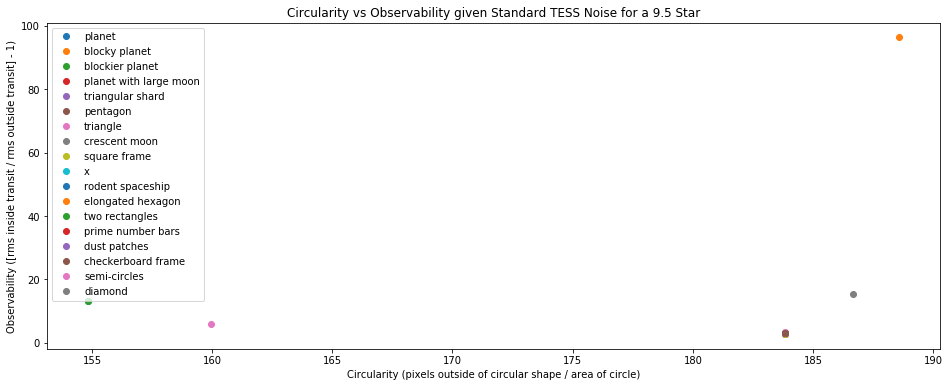

In [1778]:
plt.figure(figsize=(16,6))
plt.title("Circularity vs Observability given Standard TESS Noise for a "+str(circ_plot['mag'])+" Star")
for i in range(len(circ_plot['label'])):
    if i != 7:
        if i != 11:
            plt.plot(circ_plot['circ'][i],circ_plot['observ'][i],'o',label=str(circ_plot['label'][i]))

plt.legend()
plt.ylabel("Observability ([rms inside transit / rms outside transit] - 1)")
plt.xlabel("Circularity (pixels outside of circular shape / area of circle)")
plt.show()

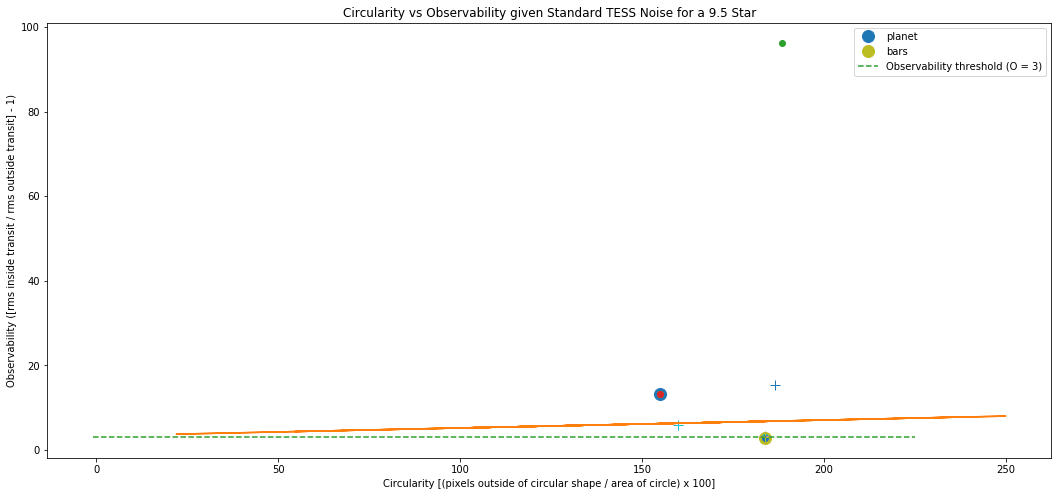

In [1779]:
y = circ_plot['observ']
x = circ_plot['circ']
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(18,8))
plt.title("Circularity vs Observability given Standard TESS Noise for a "+str(circ_plot['mag'])+" Star")
for i in range(len(circ_plot['label'])):
    if i == 0:
        plt.plot(circ_plot['circ'][i],circ_plot['observ'][i],'o',markersize=12,label=str(circ_plot['label'][i]))
    if i == 7: 
        plt.plot(circ_plot['circ'][i],circ_plot['observ'][i],'o',markersize=12,label=str(circ_plot['label'][i]))
    else:
        if i < 10:
            plt.plot(circ_plot['circ'][i],circ_plot['observ'][i],'o')
        else:
            plt.plot(circ_plot['circ'][i],circ_plot['observ'][i],'+',markersize=10)
plt.plot(x, (x*m)+b,'-')
plt.plot(np.linspace(-1,225, 200),np.linspace(3,3,200), '--', label="Observability threshold (O = 3)")
plt.legend()
plt.ylabel("Observability ([rms inside transit / rms outside transit] - 1)")
plt.xlabel("Circularity [(pixels outside of circular shape / area of circle) x 100]")
filename = "/Users/piperfrances/Downloads/10_mag_circ_observ"
plt.savefig(filename, fmt="png")
plt.show()

In [ ]:
len(circ_plot['circ'])

In [ ]:
b

In [ ]:
circ_plot['observ'][0]

In [ ]:
circ_plot['circ'][15] = area